# Backtesting and benchmarking of the trading strategies


In [ ]:
import sys

sys.path.append("..")

In [ ]:
import pandas as pd

from agents.drl_agent import DRLAgent
from benchmark.portfolio_benchmark import PortfolioBenchmark
from config import config, config_indicators
from environments.env_portfolio_optimisation import (
    PortfolioOptimisationEnvWrapper,
)
from environments.env_stock_trading import StockTradingEnvWrapper
from preprocessor.findata_preprocessor import FinancialDataPreprocessor
from visualiser.benchmark_visualiser import BenchmarkVisualiser

In [3]:
USE_CASE = "portfolio-optimisation"

In [ ]:
import os

if not os.path.exists(f"../{config.RESULTS_DIR}/{USE_CASE}"):
    os.makedirs(f"../{config.RESULTS_DIR}/{USE_CASE}")

In [ ]:
finpreprocessor = FinancialDataPreprocessor(config.START_DATE, config.END_DATE)
train_data, trade_data = finpreprocessor.load_train_test_data(
    "../" + config.DATA_DIR, config.TEST_NAME
)

In [ ]:
if USE_CASE == "stock-trading":
    environment = StockTradingEnvWrapper(
        train_data,
        trade_data,
        list(config_indicators.TECHNICAL_INDICATORS.keys()),
    )
elif USE_CASE == "portfolio-optimisation":
    environment = PortfolioOptimisationEnvWrapper(
        train_data,
        trade_data,
        list(config_indicators.TECHNICAL_INDICATORS.keys()),
    )

Environment successfully created with 
	Stock dimension: 5 
	State space: 16


In [ ]:
perf_stats = dict()
df_account = pd.DataFrame()

## Backtest the algorithms


In [ ]:
benchmark = PortfolioBenchmark()

In [ ]:
for model_name in config.MODELS:

    env_train = environment.get_train_env()
    gym_env, _ = environment.get_trade_env()

    agent = DRLAgent()

    model = agent.get_model(
        model_name,
        environment=env_train,
        directory=f"../{config.LOGS_DIR}/{USE_CASE}/{config.TEST_NAME}",
        use_case=USE_CASE,
    )

    print(f"Loading model: {model_name.upper()}")
    trained_model = agent.load_model(
        model_name,
        f"../{config.MODELS_DIR}/{USE_CASE}",
        config.TEST_NAME,
    )

    print(f"Evaluating model: {model_name.upper()}")
    df_account_alg, _ = agent.predict(trained_model, gym_env)

    # Add cumulative returns to the account dataframe
    df_account_alg["cumulative_return"] = (
        1 + df_account_alg["daily_return"]
    ).cumprod() - 1

    df_account_alg["model"] = model_name.upper()

    df_account = pd.concat([df_account, df_account_alg], ignore_index=True)

    perf_stats_alg = benchmark.compute_perf_stats(df_account_alg)

    perf_stats[model_name.upper()] = perf_stats_alg  # type: ignore

Model arguments: {'n_steps': 10, 'ent_coef': 0.005, 'learning_rate': 0.0004}
Loading model: A2C
Model successfully loaded from ../models/portfolio-optimisation/test_a2c
Evaluating model: A2C
Model arguments: {'n_steps': 2048, 'ent_coef': 0.005, 'learning_rate': 0.001, 'batch_size': 128}
Loading model: PPO
Model successfully loaded from ../models/portfolio-optimisation/test_ppo
Evaluating model: PPO
Model arguments: {'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}
Loading model: DDPG
Model successfully loaded from ../models/portfolio-optimisation/test_ddpg
Evaluating model: DDPG
Model arguments: {'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Loading model: TD3
Model successfully loaded from ../models/portfolio-optimisation/test_td3
Evaluating model: TD3
Model arguments: {'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0003, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Loading model: SAC
Model successfully loaded from ../models/portf

In [ ]:
benchmark.set_data(train_data, trade_data)

Test start date is not a trading date in the dataset.
Using next available trading date: 2024-01-02


In [ ]:
for strategy in ["mean", "min", "momentum", "equal"]:
    print(f"Optimising portfolio with strategy: {strategy}")

    df_account_strat = benchmark.optimise_portfolio(
        strategy=strategy,  # type: ignore
        initial_capital=1000000,
    )

    # Add cumulative returns to the account dataframe
    df_account_strat["cumulative_return"] = (
        1 + df_account_strat["daily_return"]
    ).cumprod() - 1

    df_account_strat["model"] = strategy.capitalize()
    df_account = pd.concat([df_account, df_account_strat], ignore_index=True)

    perf_stats_alg = benchmark.compute_perf_stats(df_account_strat)
    perf_stats[strategy.capitalize()] = perf_stats_alg  # type: ignore

Optimising portfolio with strategy: mean


Optimising portfolio with strategy: min
Optimising portfolio with strategy: momentum
Optimising portfolio with strategy: equal


In [ ]:
perf_stats = pd.DataFrame(perf_stats)
perf_stats.to_csv(
    f"../{config.RESULTS_DIR}/{USE_CASE}/performance_stats_{config.TEST_NAME}.csv",
    index=True,
)

In [ ]:
perf_stats

,A2C,PPO,DDPG,TD3,SAC,Mean,Min,Momentum,Equal
Annual return,0.289795,0.349402,0.455717,0.419794,0.368962,0.153527,0.194064,0.438389,0.362958
Cumulative returns,0.289795,0.349402,0.455717,0.419794,0.368962,0.152873,0.193224,0.436315,0.361284
Annual volatility,0.191710,0.231835,0.318298,0.277270,0.278562,0.308069,0.132776,0.621888,0.230795
Sharpe ratio,1.423407,1.408395,1.337869,1.402256,1.265640,0.616841,1.402517,0.888633,1.457078
Calmar ratio,2.391536,2.516338,2.456732,2.749485,2.291360,0.652410,2.170452,1.145905,2.627320
Stability,0.788354,0.752704,0.713312,0.748797,0.659340,0.005750,0.785308,0.177377,0.752258
Max drawdown,-0.121175,-0.138853,-0.185497,-0.152681,-0.161023,-0.235323,-0.089412,-0.382570,-0.138148
Omega ratio,1.272124,1.268388,1.248995,1.265006,1.239344,1.107622,1.268801,1.159934,1.279188
Sortino ratio,2.140924,2.155814,2.125706,2.211264,2.014586,0.909285,2.006300,1.442707,2.230460
Skew,0.143231,0.282213,0.538822,0.479355,0.705070,0.156126,-0.426623,0.812282,0.267629


## Visually compare portfolio value and cumulative returns


In [ ]:
benchmark_visualiser = BenchmarkVisualiser()

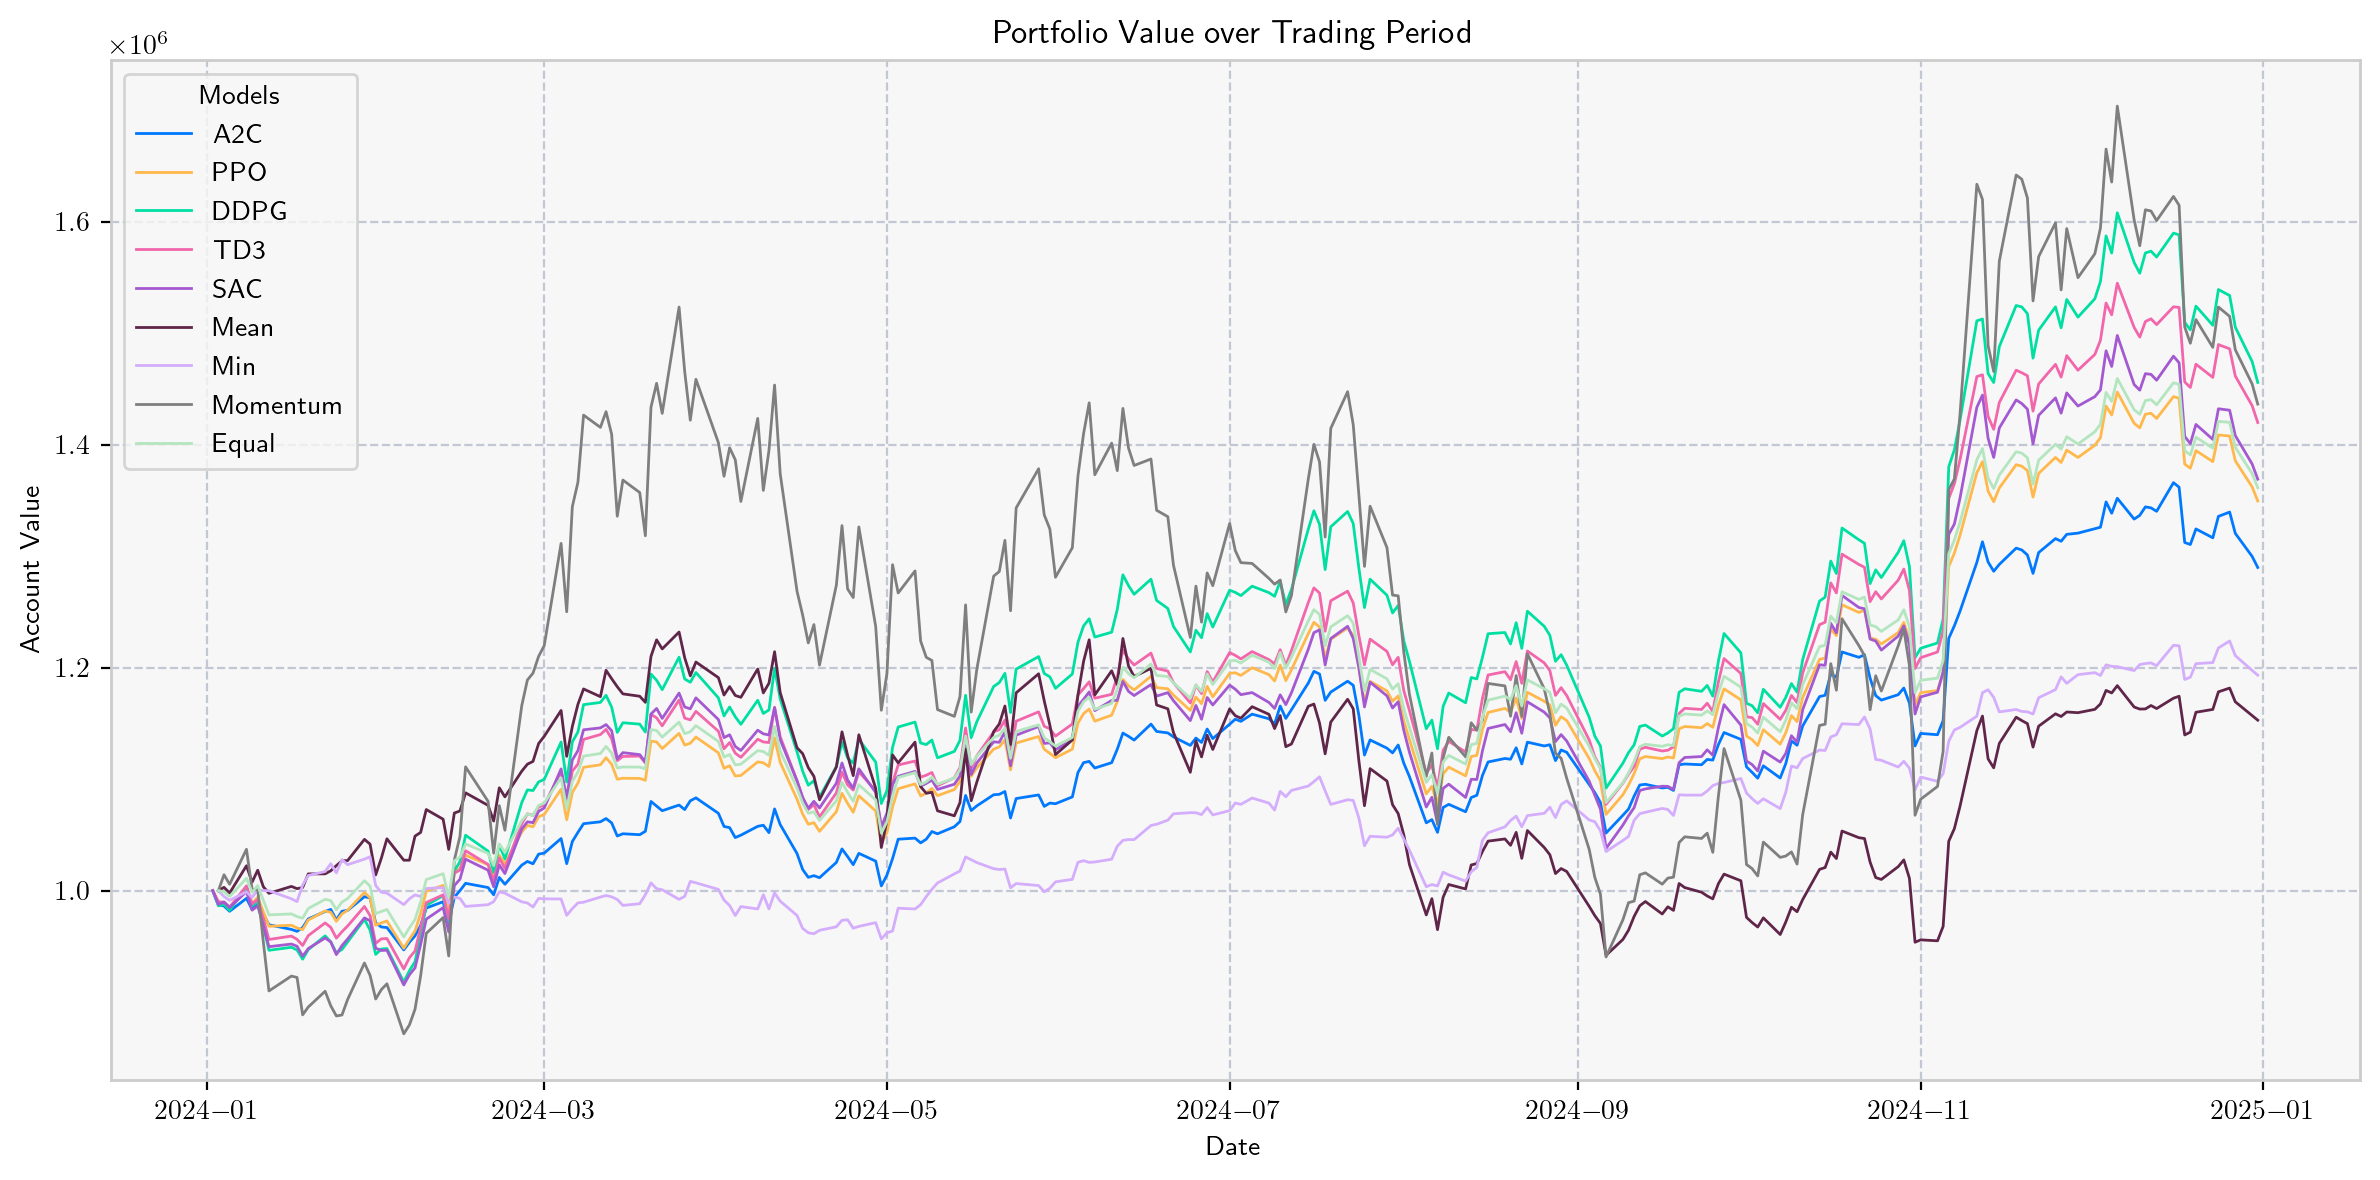

In [ ]:
benchmark_visualiser.compare_account_value(
    df_account, f"../{config.PLOT_DIR}", f"{config.TEST_NAME}_{USE_CASE}"
)

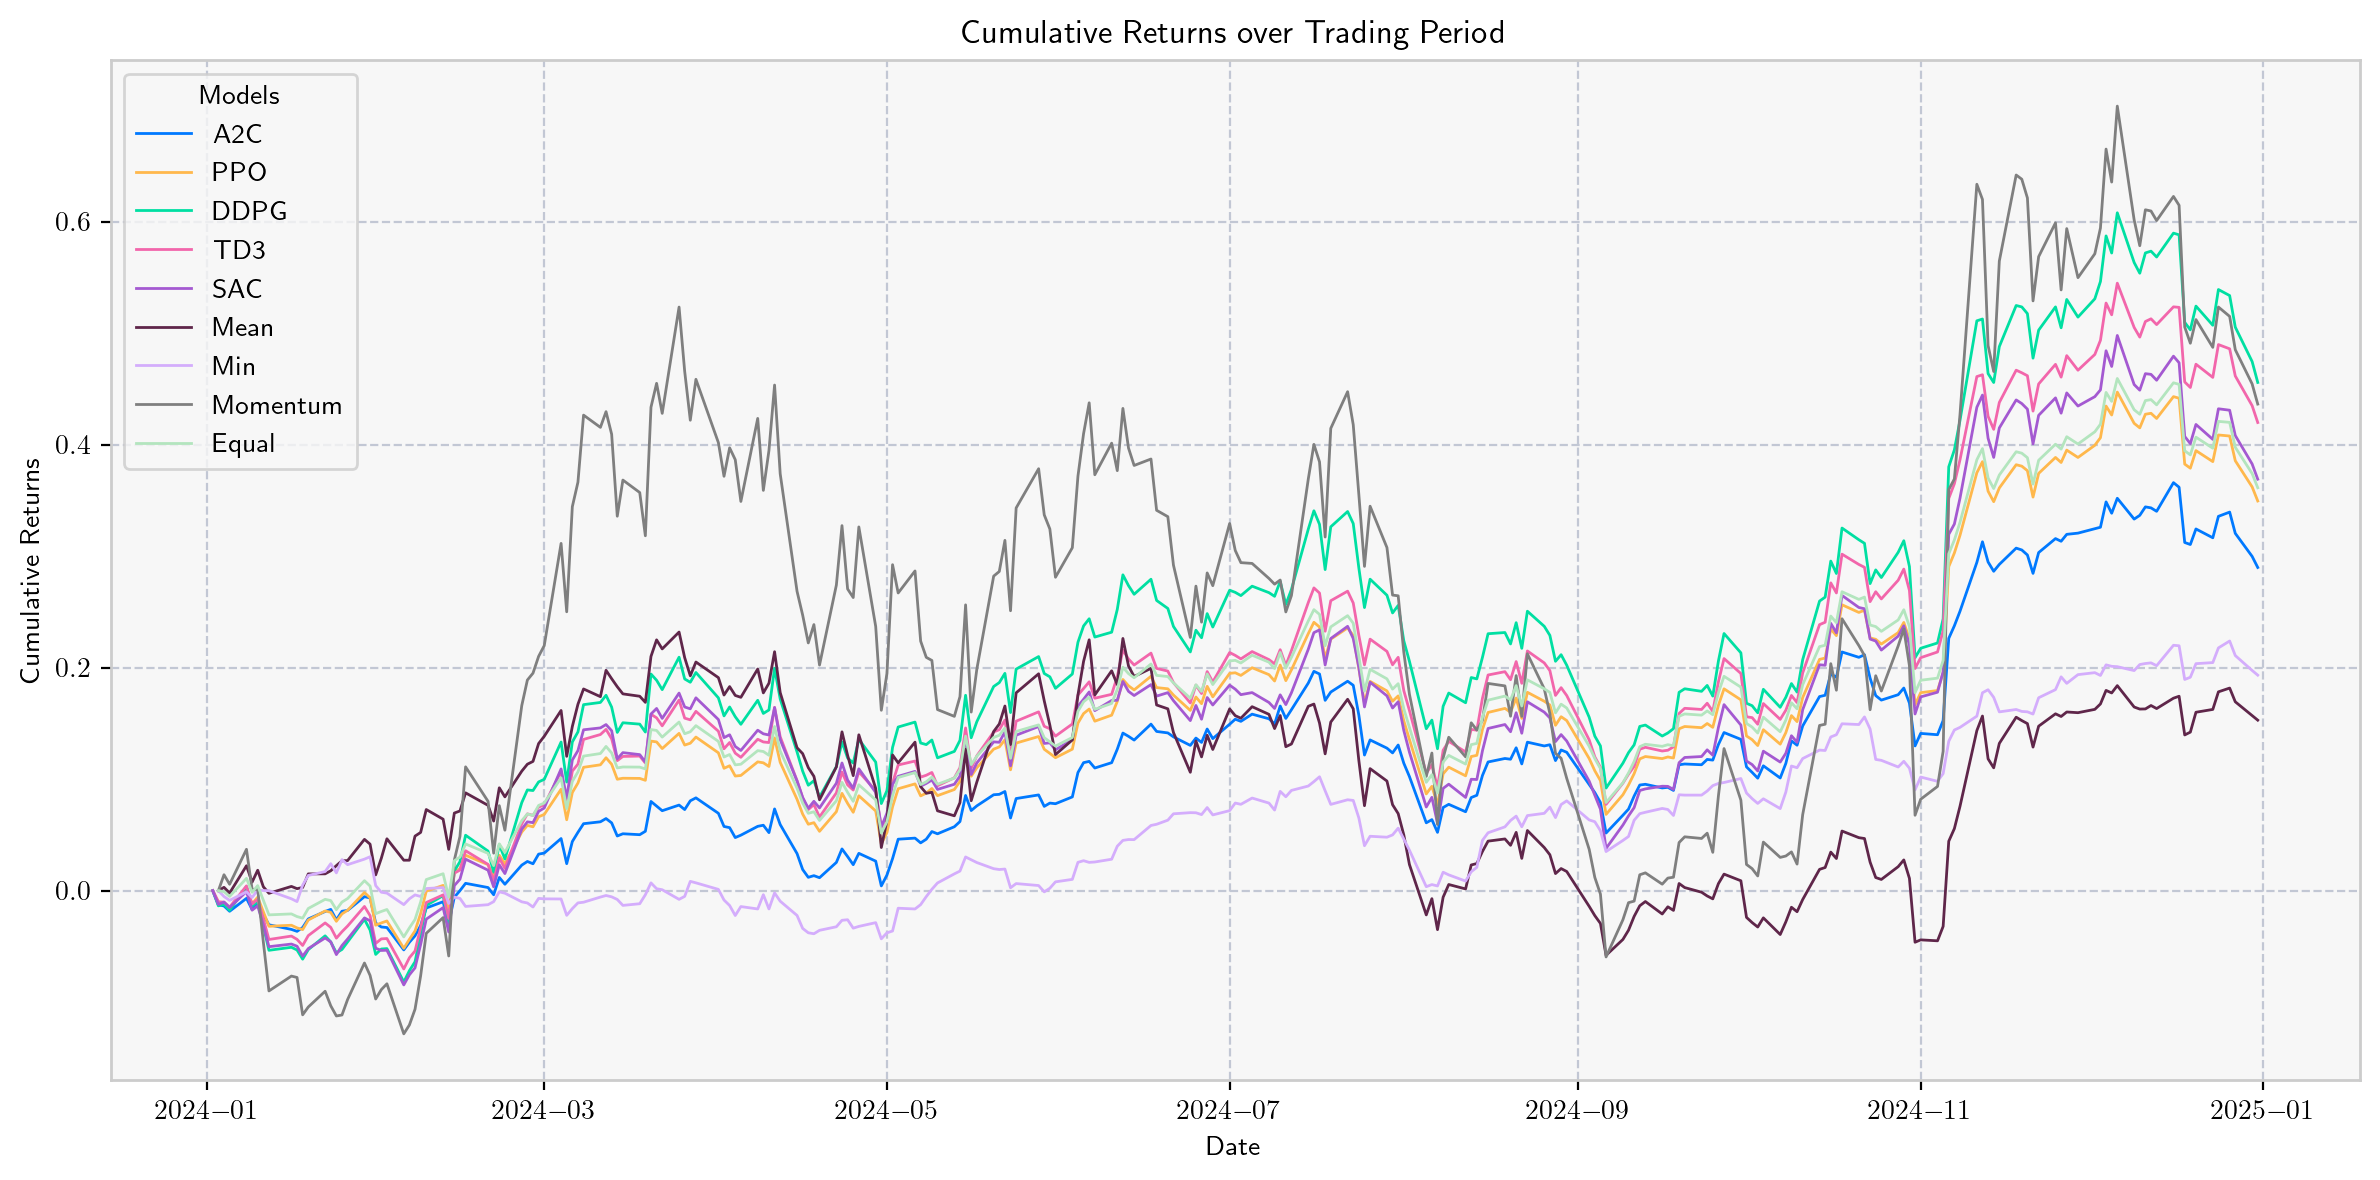

In [ ]:
benchmark_visualiser.compare_cum_returns(
    df_account, f"../{config.PLOT_DIR}", f"{config.TEST_NAME}_{USE_CASE}"
)